# Recommendation System - Matrix Factoization (Collaboratvie Filtering) using Surprise Library

##### Data is [MovieLens](https://grouplens.org/datasets/movielens/) data

In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import os

from fastai import *
from fastai.collab import *
from fastai.tabular import *
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict #data colector

#Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import accuracy
from surprise import KNNBasic

  ##CrossValidation
from surprise.model_selection import cross_validate

##Matrix Factorization Algorithms
from surprise import SVD
from surprise import NMF

np.random.seed(623) # replicating results

# 1. Load Data

In [2]:
# Opening ZIP file  
# from io import BytesIO
# from zipfile import ZipFile
# from urllib.request import urlopen

# r = urlopen("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
# zipfile = ZipFile(BytesIO(r.read()))

# rating_data = pd.read_csv(zipfile.open('ml-latest-small/ratings.csv'))
# movie_data = pd.read_csv(zipfile.open('ml-latest-small/movies.csv'))

In [3]:
pth = os.getcwd()

In [4]:
rating_data  = pd.read_csv(os.path.join(pth,'ratings.csv'))
movie_data  = pd.read_csv(os.path.join(pth,'movies.csv'))

In [5]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movie_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# 2. PreProcessing

In [7]:
min_ratings = 2 
min_ratings_count =  5 
# Delete movie rated under 2 
# Delete movie rated less than 5 times
ratings_flrd_df = rating_data.groupby("movieId").filter(lambda x: x['movieId'].count() >= min_ratings)
ratings_flrd_df = ratings_flrd_df.groupby("userId").filter(lambda x: x['userId'].count() >= min_ratings_count)

In [9]:
ratings_flrd_df.shape

(97390, 4)

When upload your own rating dataset either from a file (e.g. csv), a seprate reader should be defined
Reference is [here](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset)

In [11]:
reader = Reader(rating_scale=(0.5, 5)) #line_format by default order of the fields

# Surprise Dataset Load method
data = Dataset.load_from_df(ratings_flrd_df[["userId","movieId","rating"]], reader=reader)

trainset = data.build_full_trainset()

testset = trainset.build_anti_testset()

In [14]:
trainset

Matrix Factorization

Hopcroft and Kannan (2012), explains the whole concept of matrix factorization on customer data where m customers buy n products. The authors explain collaborative filtering in a comprehensive language. For demonstrative purposes, the author of this article demonstrates the concept on a specific case.

Let matrix $R_{m*n}$ represent the ratings on movies assigned by each user, also called the utility matrix. Specifically, the value $r_{ij} = 5$ represents the rating of user i assigned to movie j. However, the individual's preference is determined by k factors. For example, the user's age, sex, income, education, etc. are likely to affect the user's behavior. Accordingly, the individual's rating of a movie ($r_{ij}$) is determined by some weighted combinations of the hidden factors. In practice, customer's behavior can be characterized by a k-dimensional vector with much lower dimensions than the original matrix $R$ with $m * n$ dimensions. The vector's components, also called the latent factors, represent the weight of each factor. For example, given a vector $v_2 = [0.2 , 0.8]$ it can be hypothesized that there are only two (unknown) latent factors with subsequent weights describing the rating (behavior).

Matrix factorization is an effective CF technique because it benefits from the properties of linear algebra. Specifically, consider matrix $R$ as a record of various elements. As it is possible to decompose any integer into the product of its prime factor, matrix factorization also enables humans to explore information about matrices and their functional properties an array of elements (Goodfellow, Bengio, 2016)

Singular Value Decomposition (SVD)

SVD decomposes any matrix into singular vectors and singular values. If the reader has previous experience with machine learning, particularly with dimensionality reduction, they would find traditional use of SVD in Principal Component Analysis (PCA). Simply put, SVD is equivalent to PCA after mean centering, i.e. shifting all data points so that their mean is on the origin (Gillis, 2014).

Formally, SVD is decomposition of a matrix R into the product of three matrices: $R_{m*n} = U_{m*m} D_{m*n} V_{n*n}^{t}$.

Where $R_{m*n}$ denotes the utility matrix with n equal to the number of e.g. users and m number exposed items (movies). $U_{m*m}$ is a left singular orthogonal matrix, representing the relationship between users and latent factors (Hopcroft & Kannan, 2012). $D_{m*n}$ is a diagonal matrix (with positive real values) describing the strength of each latent factor. $V_{n*n}^{t}$ (transpose) is a right singular orthogonal matrix, indicating the similarity between items and latent factors.

The general goal of SVD (and other matrix factorization methods) is to decompose the matrix R with all missing $r_{ij}$ and multiply its components $U_{m*m} D_{m*n} V_{n*n}^{t}$ once again. As a result, there are no missing values $r_{ij}$ and it is possible to recommend each user movies (items) they have not seen or purchased yet. To better understand linear algebra behind SVD, one can watch Gilbert Strang's lecture on SVD for MIT OpenCourseWare on YouTube channel or visit refer to NIT Singular Value Decomposition (SVD) tutorial.

Reference: 
(1) https://www.cs.cornell.edu/jeh/book.pdf
(2) https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/#:~:text=In%20the%20context%20of%20the,given%20to%20items%20by%20users.

### Surprise Library has a built-in SVD Computation 

##### The following function computes the Cross validated RMSE. And, the return contains 100 measures of min RMSE given 100 consecutive values of k in each test set, and by five folds in every iteration (from [surprise document](http://surpriselib.com/))

In [15]:
# Just checking the effect of number of latent factors k on the model's performance.
def rmse_vs_factors(algorithm, data):
    """Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 101, 1) 100 values 
    Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
    """
    rmse_algorithm = []
    
    for k in range(1, 101, 1):
        algo = algorithm(n_factors = k)

        #["test_rmse"] is a numpy array with min accuracy value for each testset
        loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)["test_rmse"].mean() 
        rmse_algorithm.append(loss_fce)
  
    return rmse_algorithm

In [16]:
rmse_svd = rmse_vs_factors(SVD,data)

In [17]:
rmse_svd

[0.8640701175512149,
 0.8638769168745929,
 0.8637510800022202,
 0.8647810806707433,
 0.8630269836485123,
 0.8645231696291852,
 0.8637202865052265,
 0.8653130504980988,
 0.8651309812188954,
 0.8639277704232035,
 0.8643845731386314,
 0.8642636198723611,
 0.8636404957627614,
 0.8635472186317541,
 0.8630540896887444,
 0.8646289674927801,
 0.8644148449973146,
 0.8647752962643429,
 0.863489924117179,
 0.863763619597148,
 0.8643895617697609,
 0.8641200537928475,
 0.8646901769902537,
 0.8645757957332838,
 0.8645621484022519,
 0.8643118397484937,
 0.8639517832384405,
 0.8640837187371281,
 0.8648788040001444,
 0.8638063897068632,
 0.8643820853322743,
 0.8645563355224608,
 0.8651725056535128,
 0.8643567704716653,
 0.8656419522972746,
 0.8649302076143298,
 0.8650170850424029,
 0.8645597711881864,
 0.8651011379056058,
 0.8647809429792133,
 0.8661189481648073,
 0.8661791376317639,
 0.8643815017493012,
 0.8659318947507512,
 0.8647480138846344,
 0.8650681506913702,
 0.8656506614550313,
 0.867181141491

1. function plot_rmse() with two arguments where rmse is a list of float values and algorithm is an instantiated matrix factorization model. 
2. The function returns a plot with two line subplots that display performance vs. numbers of factors.

In [18]:
def plot_rmse(rmse, algorithm):
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')
        
    plt.subplot(2,1,1)
    plt.plot(rmse)
    plt.xlim(0,100)
    plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
    plt.ylabel("Mean RMSE (cv=5)")

    plt.subplot(2,1,2)
    plt.plot(rmse)
    plt.xlim(0,50)
    plt.xticks(np.arange(0, 52, step=2))

    plt.xlabel("{0}(n_factor = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")
    plt.axvline(np.argmin(rmse), color = "r")

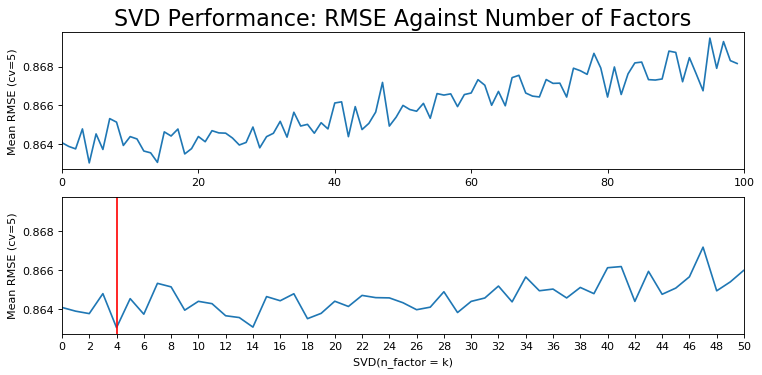

In [19]:
plot_rmse(rmse_svd,"SVD")

According to the figure, there is an increasing trend of worse performance with higher k. The lowest RMSE is achieved when $k=4$. However, it is worth mentioning that $k=14$ is also very close to the RMSE achieved with only 4 latent factors. Besides, the author argues that it is not probable that the user's taste (rating) is determined by such a low number of factors. On the other hand, the result suggests a range of values which can be used in GridSearchCV()for parameter tunning.

In [20]:
param_grid = {'n_factors': [4,6,9,11,14,18,29]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)
gs.fit(data)


# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8633595626314179
{'n_factors': 18}


#### To make the model generalizable, i.e. avoid over and underfitting, the grid algorithm finds $n_factors = 18$ optimal.

#### Then, Training SVD Algorithm and Predictions
#### To predict ratings, for each empty element $a_{ij}$ in the utility matrix, it is essential to specify: a.) the users and b.) particular movies that are not in the trainset. So, build_anti_testset() method of trainset accomplishes the goal

In [21]:
algo_SVD = SVD(n_factors = 18)
algo_SVD.fit(trainset)


# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)

# subset of the list  predictions
predictions[0:2]

[Prediction(uid=1, iid=318, r_ui=3.5110432282575212, est=5, details={'was_impossible': False}),
 Prediction(uid=1, iid=1704, r_ui=3.5110432282575212, est=4.750784530374444, details={'was_impossible': False})]

## Predictions

In [22]:
def get_top_n(predictions, userId, movies_df, ratings_df, n = 10):
    '''Return the top N (default) movieId for a user,.i.e. userID and history for comparisom
    Args:
    Returns: 
  
    '''
    #Peart I.: Surprise docomuntation
    
    #1. First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #2. Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[: n ]
    
    #Part II.: inspired by: https://beckernick.github.io/matrix-factorization-recommender/
    
    #3. Tells how many movies the user has already rated
    user_data = ratings_df[ratings_df.userId == (userId)]
    print('User {0} has already rated {1} movies.'.format(userId, user_data.shape[0]))

    
    #4. Data Frame with predictions. 
    preds_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_n.items() for pair in row],
                        columns=["userId" ,"movieId","rat_pred"])
    
    
    #5. Return pred_usr, i.e. top N recommended movies with (merged) titles and genres. 
    pred_usr = preds_df[preds_df["userId"] == (userId)].merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
            
    #6. Return hist_usr, i.e. top N historically rated movies with (merged) titles and genres for holistic evaluation
    hist_usr = ratings_df[ratings_df.userId == (userId) ].sort_values("rating", ascending = False).merge\
    (movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId')
    
    
    return hist_usr, pred_usr

**SVD Recommendations

Since the model was properly trained, it is already possible to suggest any userID n movies at this stage. Additionally, based on the acquired predictions and defined get_top_n() function it is reasonable to visually inspect the recommended movies and the user's highest rated movies in the past. For instance, let's assume the userId 124 wants to watch a movie at their earliest convenience but has no specific title in mind. On top of that, the movie database contains over 6,000 titles across multiple genres so the user would spend a lot of time researching for what movies are in line with respect to their specific preferences. The following code makes the user's choice much easier. After calling get_top_n() function, it is immediately obvious the user 124 has already rated 50 movies.

In [24]:
hist_SVD_124, pred_SVD_124 = get_top_n(predictions, movies_df = movie_data, userId = 124, ratings_df = rating_data)

User 124 has already rated 50 movies.


In [25]:
# To see the user's history, let's examine their top 15 highest rated movies
hist_SVD_124.head(15)

,userId,movieId,rating,timestamp,title,genres
0,124,1358,5.0,1336409590,Sling Blade (1996),Drama
1,124,3949,5.0,1336413175,Requiem for a Dream (2000),Drama
2,124,7361,5.0,1336413015,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3,124,6377,5.0,1336584435,Finding Nemo (2003),Adventure|Animation|Children|Comedy
4,124,2858,5.0,1336584459,American Beauty (1999),Drama|Romance
5,124,356,5.0,1336423402,Forrest Gump (1994),Comedy|Drama|Romance|War
6,124,608,5.0,1336412883,Fargo (1996),Comedy|Crime|Drama|Thriller
7,124,3252,4.5,1336409712,Scent of a Woman (1992),Drama
8,124,1210,4.5,1336584462,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
9,124,1196,4.5,1336584447,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi


In [26]:
# Prediction
pred_SVD_124

,userId,movieId,rat_pred,title,genres
0,124,750,4.600220,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
1,124,1204,4.577019,Lawrence of Arabia (1962),Adventure|Drama|War
2,124,904,4.561244,Rear Window (1954),Mystery|Thriller
3,124,2959,4.529422,Fight Club (1999),Action|Crime|Drama|Thriller
4,124,1104,4.519563,"Streetcar Named Desire, A (1951)",Drama
5,124,912,4.513226,Casablanca (1942),Drama|Romance
6,124,2571,4.501588,"Matrix, The (1999)",Action|Sci-Fi|Thriller
7,124,4973,4.494541,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
8,124,2324,4.493342,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War
9,124,898,4.493223,"Philadelphia Story, The (1940)",Comedy|Drama|Romance


#### TODO: Try another algorithm (other than SVD) to see if there are any characteristics that you could find in prediction

#### Refernece: 
##### (1) https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af
##### (2) Sarwar, Badrul & Badrul, & Karypis, George & Cybenko, George & Konstan, & Joseph, & Reidl, & Tsibouklis, John. (2001). Item-based collaborative filtering recommendation algorithmus.